# Линейная регрессия.

In [7]:
import numpy as np
import pandas as pd
import torch
from torch import autograd

import matplotlib.pyplot as plt

## Зарузка данных.

Стоимость недвижимости в Бостоне (новая версия).

In [8]:
# CRIM     уровень преступности на душу населения 
# ZN       доля жилой земли, зонированной на участки площадью более 25 000 кв.футов.
# INDUS    доля акров, не связанных с розничной торговлей, на город
# CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
# NOX      концентрация оксидов азота (частей на 10 миллионов)
# RM       среднее количество комнат в жилом помещении
# AGE      доля жилых помещений, занятых владельцами, построенных до 1940 года
# DIS      взвешенные расстояния до пяти бостонских центров занятости
# RAD      индекс доступности к радиальным магистралям
# TAX      ставка налога на недвижимость с полной стоимостью за $10,000
# PTRATIO  соотношение учащихся и учителей по городам
# B        1000(Bk - 0.63)^2 где Bk - доля чернокожих по городам
# LSTAT    % населения низкого статуса
# MEDV     Средняя стоимость домов, занятых владельцами, в 1000 долларов

columns_name = ['CRIM',
                'ZN',
                'INDUS',
                'CHAS',
                'NOX',
                'RM',
                'AGE',
                'DIS',
                'RAD',
                'TAX',
                'PTRATIO',
                'B',
                'LSTAT',
                'MEDV']

In [10]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
# target = raw_df.values[1::2, 2]

In [12]:
type(data)

numpy.ndarray

In [2]:
x = torch.arange(4).type(torch.float)
print(x)

tensor([0., 1., 2., 3.])


## Присоединение градиента к `x`

- Говорит системе, что мы хотим хранить градиент

In [3]:
x.requires_grad

False

In [4]:
x = x.requires_grad_()

In [5]:
x.requires_grad

True

In [6]:
x.grad

## Forward

вычислим 

$$y = 2\mathbf{x}^{\top}\mathbf{x}$$

In [7]:
y = 2 * x.dot(x)

In [8]:
y

tensor(28., grad_fn=<MulBackward0>)

## Backward

In [9]:
y.backward()

## Получение градиента

$y = 2\mathbf{x}^{\top}\mathbf{x}$, значит 

$$\frac{\partial y}{\partial \mathbf x} = 4\mathbf{x}$$

Проверим:

In [10]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [11]:
4 * x == x.grad

tensor([True, True, True, True])

## no_grad

функция no_grad позволяет отключить вычисление градиента для части кода

In [12]:
y = 2 * x.dot(x)
print(y.grad_fn)
with torch.no_grad():
    y = 2 * x.dot(x)
    print(y.grad_fn)

None


In [15]:
y = 2 * x.dot(x)
y.backward()
print(x.grad)
with torch.no_grad():
    y = 2 * x.dot(x)
    y.backward()
    print(x.grad)

tensor([ 0., 12., 24., 36.])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Гибкий граф

In [16]:
def f(a):
    b = a * 2
    while b.norm().item() < 1000:
        b = b * 2
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [17]:
a = torch.randn(1).requires_grad_()
d = f(a)
d.backward()

In [18]:
d

tensor([1017.0656], grad_fn=<MulBackward0>)

In [19]:
a

tensor([0.4966], requires_grad=True)

## Практика

1. Пусть $f(x) = \sin(x) * x$. Постройте график $f(x)$ и $\frac{df(x)}{dx}$ используя пакет autograd'а для расчета производных (т.е. нельзя выводить производную явно)

## Линейная регрессия с нуля

In [20]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import torch
import random

## Генерируем данные

- Случайно генерируем $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
- Выбираем значения весов (истинные): $\mathbf{w} = [2, -3.4]^\top$ и свободного члена $b = 4.2$
- Генерируем метки по формле $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  с шумом $\epsilon$ нормально распределнным с мат ожиданием 0 и дисперсией 1

In [21]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

## Визуализируем данные

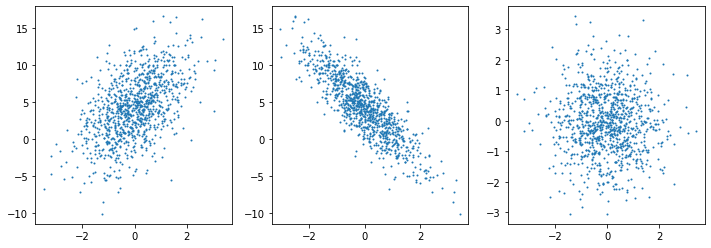

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(features[:, 0], labels, 1)
plt.subplot(132)
plt.scatter(features[:, 1], labels, 1)
plt.subplot(133)
plt.scatter(features[:, 0], features[:, 1], 1)
plt.show()

## Чтение данных

Итерируемся по датасету и возвращаем случаные `batch_size` примеров.

In [23]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i: min(i + batch_size, num_examples)]
        yield features[j, :], labels[j]

## Выводим маленький батч

In [24]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-1.0863, -0.6249],
        [-1.5820, -0.1916],
        [ 1.6020,  2.0665],
        [ 0.9247,  0.3049],
        [ 0.2413,  0.1428],
        [ 1.1201, -1.5100],
        [-0.6600,  1.2016],
        [ 0.2746, -0.4084],
        [ 0.1540,  0.1386],
        [ 0.5785, -0.9434]]) tensor([ 3.4596,  1.8752,  0.7951,  5.1091,  6.2787, 10.5065, -0.6251,  4.0188,
         5.0797,  9.0937])


### Создаем нашу модель для обучения

In [25]:
w = torch.randn((num_inputs))
b = torch.zeros((1,))

In [26]:
w.requires_grad_()
b.requires_grad_()

tensor([0.], requires_grad=True)

## Практика - реализуйте функции:
- linreg - применение модели линейной регресии
- squared_loss - MSE функция потерь
- sgd - стохастический шаг градиентного спуска по массиву параметров

и допишите код обучения линейной регрессии

In [27]:
def linreg(X, w, b):

SyntaxError: incomplete input (468068021.py, line 1)

### Обучение

In [28]:
def squared_loss(y_hat, y):

SyntaxError: incomplete input (3276562676.py, line 1)

In [29]:
def sgd(params, lr, batch_size):

SyntaxError: incomplete input (3076052398.py, line 1)

In [30]:
lr = 0.01  
num_epochs = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):   
        w = w.detach()
        b = b.detach()
        w.requires_grad_()
        b.requires_grad_()
        
        #
        # ТУТ КОД 
        #

    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

NameError: name 'squared_loss' is not defined

## Оценка качества модели

In [31]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)
print(w)
print(b)

Error in estimating w tensor([ 2.9522, -4.7263], grad_fn=<SubBackward0>)
Error in estimating b tensor([4.2000], grad_fn=<RsubBackward1>)
tensor([-0.9522,  1.3263], requires_grad=True)
tensor([0.], requires_grad=True)


## Линейная регрессия на torch

In [32]:
from torch.utils.data import TensorDataset, DataLoader

In [33]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

In [34]:
batch_size = 10
dataset = TensorDataset(features, labels)
# Randomly reading mini-batches
data_iter = DataLoader(dataset, batch_size, shuffle=True)

# Read a batch to see how it works
for X, y in data_iter:
    print(X, y)
    break

tensor([[-0.2670,  0.3546],
        [-0.5627, -0.4120],
        [ 0.5638, -1.3643],
        [ 1.1191,  1.4518],
        [-0.0628,  0.1485],
        [ 0.7852,  0.4838],
        [ 0.4935, -0.5786],
        [-0.6270, -1.0029],
        [-0.2124, -1.0249],
        [ 0.7296,  0.8066]]) tensor([ 1.5079,  5.7120, 10.4150,  0.2680,  5.1266,  4.6874,  8.1546,  7.3353,
         7.2518,  3.3851])


In [35]:
model = torch.nn.Sequential(torch.nn.Linear(2, 1))

In [36]:
model[0].weight.data = true_w.clone().detach().requires_grad_(True).reshape((1, 2))
model[0].bias.data = torch.tensor([true_b], requires_grad = True)

In [37]:
loss = torch.nn.MSELoss(reduction='mean')

In [38]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [39]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(model.forward(X).reshape(-1), y)
        l.backward()
        trainer.step()
    l = loss(model.forward(features).reshape(-1), labels)
    print('epoch %d, loss: %f' % (epoch, l.item()))
    print('w', model[0].weight.data)
    print('b', model[0].bias.data)

epoch 1, loss: 0.940392
w tensor([[ 1.9968, -3.3984]])
b tensor([4.2041])
epoch 2, loss: 0.940225
w tensor([[ 1.9952, -3.3972]])
b tensor([4.2077])
epoch 3, loss: 0.940101
w tensor([[ 1.9933, -3.3958]])
b tensor([4.2106])
epoch 4, loss: 0.940039
w tensor([[ 1.9924, -3.3951]])
b tensor([4.2126])
epoch 5, loss: 0.939988
w tensor([[ 1.9915, -3.3940]])
b tensor([4.2145])
epoch 6, loss: 0.939953
w tensor([[ 1.9905, -3.3933]])
b tensor([4.2160])
epoch 7, loss: 0.939928
w tensor([[ 1.9892, -3.3927]])
b tensor([4.2169])
epoch 8, loss: 0.939909
w tensor([[ 1.9881, -3.3927]])
b tensor([4.2181])
epoch 9, loss: 0.939907
w tensor([[ 1.9882, -3.3924]])
b tensor([4.2183])
epoch 10, loss: 0.939896
w tensor([[ 1.9879, -3.3922]])
b tensor([4.2197])
epoch 11, loss: 0.939892
w tensor([[ 1.9878, -3.3918]])
b tensor([4.2202])
epoch 12, loss: 0.939889
w tensor([[ 1.9874, -3.3923]])
b tensor([4.2207])
epoch 13, loss: 0.939887
w tensor([[ 1.9872, -3.3924]])
b tensor([4.2211])
epoch 14, loss: 0.939884
w tensor(

In [435]:
w = model[0].weight.data
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = model[0].bias.data
print('Error in estimating b', true_b - b)

Error in estimating w tensor([[0.0119, 0.0260]])
Error in estimating b tensor([-0.0006])


In [436]:
model[0].weight.data

tensor([[ 1.9881, -3.4260]])

In [437]:
model[0].bias.data

tensor([4.2006])

# Наивный байесовский классификатор.